# First glance on TSLA stock

In [1]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame
import math
import numpy as np
import time

start = datetime.datetime(2011, 1, 1)
end = datetime.datetime(2019, 1, 1)
stock_name = 'TSLA'


df = web.DataReader(stock_name, 'yahoo', start, end)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-12-24,314.500000,295.200012,313.500000,295.390015,5559900,295.390015
2018-12-26,326.970001,294.089996,300.000000,326.089996,8163100,326.089996
2018-12-27,322.170013,301.500000,319.839996,316.130005,8575100,316.130005
2018-12-28,336.239990,318.410004,323.100006,333.869995,9939000,333.869995
2018-12-31,339.209991,325.260010,337.790009,332.799988,6302300,332.799988


In [2]:
# calculate moving average
window = 100
close_px = df['Adj Close']
mavg = close_px.rolling(window=window).mean()

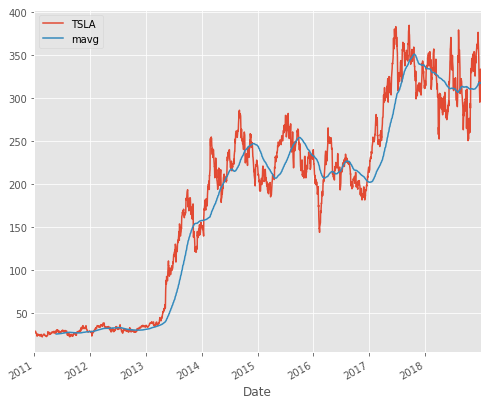

In [3]:
# initial plotting
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='TSLA')
mavg.plot(label='mavg')
plt.legend()

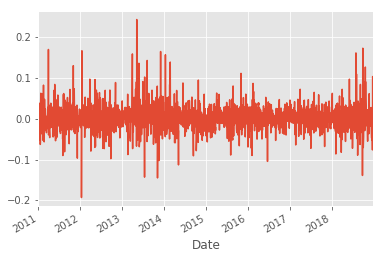

In [4]:
# find expected returns
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')

# Analyze other stocks

In [5]:
# read in data
comparing_stocks = ['AAPL', 'GOOG', 'AMZN', 'SAP', 'MSFT']
dfcomp = web.DataReader(['AAPL', 'GOOG', 'AMZN', 'SAP', 'MSFT'], 'yahoo', start=start, end=end)['Adj Close']
dfcomp.head()

Symbols,AAPL,AMZN,GOOG,MSFT,SAP
Date,,,,,
2011-01-03,41.088589,184.220001,301.046600,22.558224,43.701889
2011-01-04,41.303032,185.009995,299.935760,22.646908,43.556927
2011-01-05,41.640896,187.419998,303.397797,22.574345,42.925911
2011-01-06,41.607231,185.860001,305.604523,23.235449,42.414284
2011-01-07,41.905193,185.490005,307.069031,23.058081,42.081722


In [6]:
# correlation analysis
retscomp = dfcomp.pct_change()
corr = retscomp.corr()
corr

Symbols,AAPL,AMZN,GOOG,MSFT,SAP
Symbols,,,,,
AAPL,1.000000,0.364971,0.433988,0.426584,0.387505
AMZN,0.364971,1.000000,0.549114,0.471289,0.396636
GOOG,0.433988,0.549114,1.000000,0.536333,0.428823
MSFT,0.426584,0.471289,0.536333,1.000000,0.482456
SAP,0.387505,0.396636,0.428823,0.482456,1.000000


Text(0, 0.5, 'Returns MSFT')

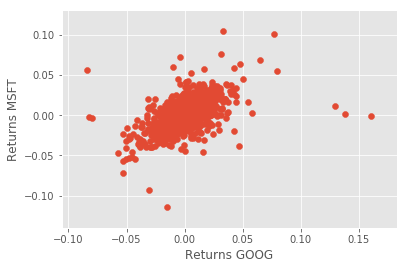

In [7]:
# plot scatter return of GOOG and MSFT
plt.scatter(retscomp.GOOG, retscomp.MSFT)
plt.xlabel('Returns GOOG')
plt.ylabel('Returns MSFT')

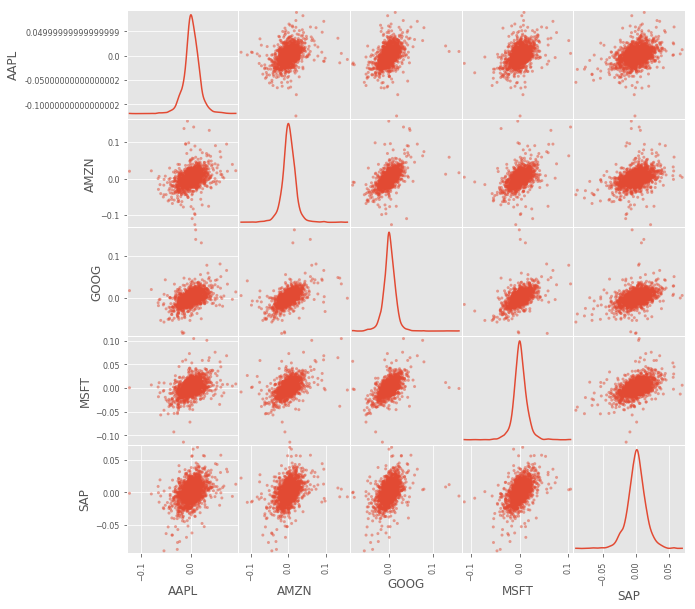

In [8]:
# plot scatter matrix
pd.plotting.scatter_matrix(retscomp, diagonal='kde', figsize=(10, 10));

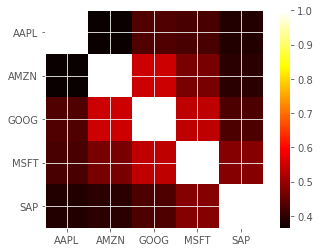

In [9]:
# heat map visualization
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns);

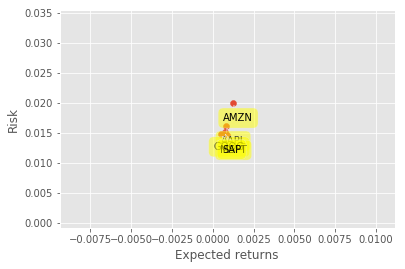

In [10]:
# plot return rates and risks
plt.scatter(retscomp.mean(), retscomp.std())
plt.xlabel('Expected returns')
plt.ylabel('Risk')
for label, x, y in zip(retscomp.columns, retscomp.mean(), retscomp.std()):
    plt.annotate(label, xy=(x,y), xytext=(20,-20), textcoords='offset points', ha='right', va='bottom', bbox=dict(boxstyle='round,pad=0.5', fc='yellow',alpha=0.5), arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

# Predicting stock price

This workbook will use three machine learning algorithms to analize the stocks:
- Support Vector Regression (SVR)
- Artificial Neural Network (ANN)
- Long-Short Term Memory (LSTM)

## Feature Engineering
First of all, the features in our dataframe should be adjusted a bit. Let's add more features - High Low Percentage and Percentage Change.

In [11]:
windows = 4
dfreg = df.loc[:,['Adj Close', 'Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.00
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100

trailling_cols = ['Adj Close', 'Volume', 'HL_PCT', 'PCT_change']
for w in range(windows):
    for col in trailling_cols:
        dfreg[col+'-'+str(w+1)] = dfreg[col].shift(w+1)
dfreg.tail()

,Adj Close,Volume,HL_PCT,PCT_change,Adj Close-1,Volume-1,HL_PCT-1,PCT_change-1,Adj Close-2,Volume-2,HL_PCT-2,PCT_change-2,Adj Close-3,Volume-3,HL_PCT-3,PCT_change-3,Adj Close-4,Volume-4,HL_PCT-4,PCT_change-4
Date,,,,,,,,,,,,,,,,,,,,
2018-12-24,295.390015,5559900,6.533731,-5.776710,319.769989,8016800.0,3.449354,0.746690,315.380005,9071900.0,5.840577,-3.568257,332.970001,8274200.0,5.186659,-1.371447,337.029999,7100000.0,5.299227,-3.854056
2018-12-26,326.089996,8163100,10.083108,8.696665,295.390015,5559900.0,6.533731,-5.776710,319.769989,8016800.0,3.449354,0.746690,315.380005,9071900.0,5.840577,-3.568257,332.970001,8274200.0,5.186659,-1.371447
2018-12-27,316.130005,8575100,6.538454,-1.159952,326.089996,8163100.0,10.083108,8.696665,295.390015,5559900.0,6.533731,-5.776710,319.769989,8016800.0,3.449354,0.746690,315.380005,9071900.0,5.840577,-3.568257
2018-12-28,333.869995,9939000,5.340398,3.333330,316.130005,8575100.0,6.538454,-1.159952,326.089996,8163100.0,10.083108,8.696665,295.390015,5559900.0,6.533731,-5.776710,319.769989,8016800.0,3.449354,0.746690
2018-12-31,332.799988,6302300,4.191701,-1.477255,333.869995,9939000.0,5.340398,3.333330,316.130005,8575100.0,6.538454,-1.159952,326.089996,8163100.0,10.083108,8.696665,295.390015,5559900.0,6.533731,-5.776710


In [12]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
# Drop missing values
dfreg = dfreg.dropna()

# Separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))

# Separating label
forecast_col = 'Adj Close'
X = np.array(dfreg.drop(['Adj Close', 'Volume', 'HL_PCT', 'PCT_change'], 1)) # remove features from the current time step to avoid data leakage

# scale the feature matrix X
X = preprocessing.scale(X)

# get train and test set
X = X
y = dfreg[forecast_col]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

In [13]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1807, 16)
(201, 16)
(1807,)
(201,)


## Start prediction!
As mentioned before, this workbook will give three examples of machine learning predictions. This part will give you more detail about it.

In [14]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from scipy import stats

from keras.layers import Dense
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

from keras.layers import LSTM

Using TensorFlow backend.


In [15]:
# utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [16]:
# SVR
np.random.seed(46)
n_iter = 20
param_dist = {'C': stats.uniform(1000, 10000),
             'gamma': stats.uniform(0.00001, 0.1),
             'epsilon': stats.uniform(0.0001, 0.1)}
svr = SVR()
random_search_svr = RandomizedSearchCV(svr, param_distributions=param_dist, n_iter=n_iter, scoring='neg_mean_squared_error')
start = time.time()
random_search_svr.fit(X_train, y_train)
elapsed_svr = (time.time() - start)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % (elapsed_svr, n_iter))
report(random_search_svr.cv_results_)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV took 279.36 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -44.495 (std: 3.539)
Parameters: {'C': 2065.5685109030464, 'epsilon': 0.05217896003888605, 'gamma': 0.0006346276335343693}

Model with rank: 2
Mean validation score: -186.341 (std: 185.250)
Parameters: {'C': 4948.319491801178, 'epsilon': 0.06287680882341898, 'gamma': 0.003608854359970072}

Model with rank: 3
Mean validation score: -402.567 (std: 467.908)
Parameters: {'C': 1580.5131621625283, 'epsilon': 0.07566654342819286, 'gamma': 0.0064702878089825675}



In [17]:
# ANN
def ANNmodel(hid_layers=[], in_dim=1, out_dim=1):
    model = Sequential()
    if len(hid_layers) == 0:
        model.add(Dense(out_dim, input_dim=in_dim, activation='relu', kernel_initializer='normal'))
    else:
        model.add(Dense(hid_layers[0], input_dim=in_dim, activation='relu', kernel_initializer='normal'))
        for layer in hid_layers:
            model.add(Dense(layer, activation='relu'))
        model.add(Dense(out_dim))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def get_hid_layers(min_layers=0, max_layers=5, min_neurons=1, max_neurons=10, n_iter=1):
    hid_layers = []
    for _ in range(n_iter):
        layers = np.random.randint(min_layers, max_layers)
        hid_layers.append(np.random.randint(low=min_neurons, high=max_neurons, size=layers).tolist())
    return hid_layers
np.random.seed(99)
n_iter = 20
param_dist = {'hid_layers': get_hid_layers(max_layers=10, min_neurons=1, max_neurons=20, n_iter=n_iter)}
ann = KerasRegressor(build_fn=ANNmodel, in_dim=X_train.shape[1], epochs=50, batch_size=256, verbose=0)
random_search_ann = GridSearchCV(estimator=ann, param_grid=param_dist, scoring='neg_mean_squared_error')
start = time.time()
random_search_ann.fit(X_train, y_train)
elapsed_ann = (time.time() - start)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % (elapsed_ann, n_iter))
report(random_search_ann.cv_results_)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV took 217.14 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -2599.121 (std: 1633.875)
Parameters: {'hid_layers': [8, 16, 16, 6]}

Model with rank: 2
Mean validation score: -3122.942 (std: 1348.176)
Parameters: {'hid_layers': [14, 8, 17, 15, 3]}

Model with rank: 3
Mean validation score: -3243.036 (std: 2414.264)
Parameters: {'hid_layers': [4, 14, 10, 13, 5, 2, 14, 12]}



In [18]:
# LSTM
def vLSTMmodel(input_shape, nNeurons=1, out_dim=1):
    model = Sequential()
    model.add(LSTM(nNeurons, input_shape=input_shape, activation='relu'))
    model.add(Dense(out_dim))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
np.random.seed(124)
n_iter = 20
param_dist = {'nNeurons': range(1, 100, 1)}
X_train_lstm = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
vlstm = KerasRegressor(build_fn=vLSTMmodel, input_shape=X_train_lstm.shape[1:], epochs=50,  verbose=0)
random_search_vlstm = RandomizedSearchCV(estimator=vlstm, param_distributions=param_dist, scoring='neg_mean_squared_error')
start = time.time()
random_search_vlstm.fit(X_train_lstm, y_train)
elapsed_lstm = (time.time() - start)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % (elapsed_lstm, n_iter))
report(random_search_vlstm.cv_results_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV took 548.13 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -3505.703 (std: 1585.339)
Parameters: {'nNeurons': 96}

Model with rank: 2
Mean validation score: -3869.493 (std: 2083.712)
Parameters: {'nNeurons': 91}

Model with rank: 3
Mean validation score: -3928.087 (std: 1889.758)
Parameters: {'nNeurons': 85}



In [19]:
best_svr = random_search_svr.best_estimator_
best_svr.fit(X_train, y_train)
best_ann = random_search_ann.best_estimator_
best_ann.fit(X_train, y_train)
best_vlstm = random_search_vlstm.best_estimator_
best_vlstm.fit(X_train_lstm, y_train)
# Evaluate
confidencesvr = best_svr.score(X_test, y_test)
confidenceann = best_ann.score(X_test, y_test)
X_test_lstm = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
confidencelstm = best_vlstm.score(X_test_lstm, y_test)

print("Support Vector Regression: ", confidencesvr)
print("Artificial Neural Network: ", confidenceann)
print("Long-Short Term Memory: ", confidencelstm)

Support Vector Regression:  0.8431998057910148
Artificial Neural Network:  -924.400390625
Long-Short Term Memory:  -413.32894943009563


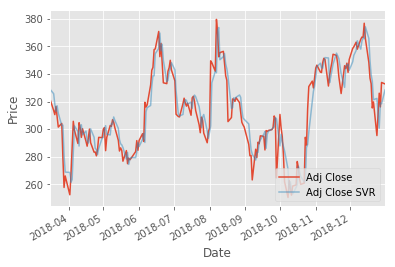

In [20]:
Adj_Close_pred  = best_svr.predict(X)
dfreg['Adj Close SVR'] = Adj_Close_pred
dfreg['Adj Close'].tail(200).plot()
dfreg['Adj Close SVR'].tail(200).plot(alpha=0.5)
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

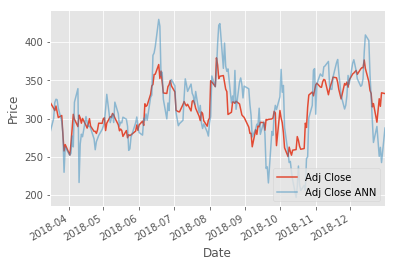

In [21]:
Adj_Close_pred  = best_ann.predict(X)
dfreg['Adj Close ANN'] = Adj_Close_pred
dfreg['Adj Close'].tail(200).plot()
dfreg['Adj Close ANN'].tail(200).plot(alpha=0.5)
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

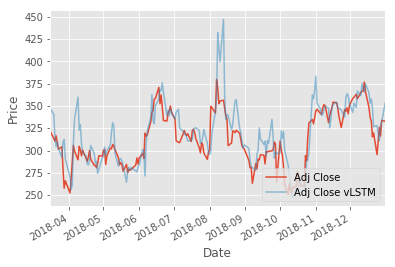

In [23]:
X_lstm = np.reshape(X, (X.shape[0], 1, X.shape[1]))
Adj_Close_pred  = best_vlstm.predict(X_lstm)
dfreg['Adj Close vLSTM'] = Adj_Close_pred
dfreg['Adj Close'].tail(200).plot()
dfreg['Adj Close vLSTM'].tail(200).plot(alpha=0.5)
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()